# 使用前，需要先导入需要的头文件

In [1]:
#include <iostream>

/*a workaround to solve cling issue*/
#include "../inc/macos_cling_workaround.hpp"
/*set libtorch path, load libs*/
#include "../inc/load_libtorch.hpp"
/*import custom defined macros*/
#include "../inc/custom_def.hpp"
/*import matplotlibcpp*/
#include "../inc/load_matplotlibcpp.hpp"
/*import opencv*/
#include "../inc/load_opencv.hpp"

/*import libtorch header file*/
#include <torch/torch.h>
#include <opencv2/opencv.hpp>
#include <cmath>

// Use (void) to silent unused warnings.
#define assertm(exp, msg) assert(((void)msg, exp))

In [2]:
class MyDataset : public torch::data::Dataset<MyDataset>
{
    private:
        torch::Tensor states_, labels_;

    public:
        explicit MyDataset(torch::Tensor states, torch::Tensor labels) 
            : states_(states),
              labels_(labels) {   };

        torch::data::Example<> get(size_t index) override {
            return {states_[index], labels_[index]};
        };

        torch::optional<size_t> size() const override {
            return states_.size(0);
        };
};

In [ ]:
def synthetic_data(w, b, num_examples):  
    """生成 y = Xw + b + 噪声。"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [ ]:
def load_array(data_arrays, batch_size, is_train=True):  
    """构造一个PyTorch数据迭代器。"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

# 权重衰减（L2正则化）

### 使用以下多项式来生成训练和测试数据

$y = 0.05 + \sum\limits_{i=1}^{d}0.01 x_i + \epsilon \quad where \quad\epsilon \sim \mathcal{N} (0,0.01^2)$

In [3]:
constexpr int n_train = 20;
constexpr int n_test = 80;
constexpr int num_inputs = 200;
constexpr int batch_size = 5;

//多项式系数
torch::Tensor true_w = torch::ones({num_inputs, 1}) * 0.01;
float true_b = 0.05;

train_features = torch::randn({n_train, true_w.size(0)});
train_labels   = train_features.mm(true_w) + true_b;
auto t = torch::randn({train_labels.size[0], train_labels.size[1]});
t = t * 0.01;
train_labels += t.reshape({t.size[0] ,1});


train_features = torch::randn({n_train, true_w.size(0)});
train_labels   = train_features.mm(true_w) + true_b;
auto t = torch::randn_like(train_labels) * 0.01;
train_labels += t.reshape({t.size[0] ,1});


test_features = torch::randn({n_test, true_w.size(0)});
test_labels   = test_features.mm(true_w) + true_b;
auto u = torch::randn_like(test_labels) * 0.01;
test_labels += u.reshape({u.size[0] ,1});

In [4]:
printT(features.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}));    
  
printT(poly_features.index({torch::indexing::Slice(torch::indexing::None, 1, torch::indexing::None)}));    

printT(labels.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}));    

features.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}) = 
 0.3411
-0.6781
[ CPUFloatType{2,1} ]
<<--->>

poly_features.index({torch::indexing::Slice(torch::indexing::None, 1, torch::indexing::None)}) = 
Columns 1 to 6 1.0000e+00  3.4114e-01  1.1638e-01  1.9850e-02  2.2572e-03  1.9251e-04

Columns 7 to 12 1.3135e-05  7.4782e-07  3.6401e-08  1.5520e-09  5.8825e-11  2.0068e-12

Columns 13 to 18 6.2235e-14  1.7692e-15 -1.3463e-16 -4.5926e-17 -1.5667e-17 -5.3447e-18

Columns 19 to 20-1.8233e-18 -6.2200e-19
[ CPUFloatType{1,20} ]
<<--->>

labels.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}) = 
 5.2098
 1.7689
[ CPUFloatType{2,1} ]
<<--->>



### 定义训练函数

In [5]:
std::vector<int> x;
std::vector<double> y;
std::vector<double> y_hat;

In [6]:
torch::Tensor train(torch::Tensor train_features, 
           torch::Tensor test_features, 
           torch::Tensor train_labels, 
           torch::Tensor test_labels,
           int num_epochs = 400,
           int batch_size = 10)
{
    assertm(train_features.dim() == 2, "train_features should have 2 dims");
    assertm(test_features.dim() == 2, "test_features should have 2 dims");
    
    auto train_data_set = MyDataset(train_features, train_labels)
//                                     .map(torch::data::transforms::Normalize<>(0, 0.5))
                                    .map(torch::data::transforms::Stack<>());
    auto test_data_set = MyDataset(test_features, test_labels)
//                                     .map(torch::data::transforms::Normalize<>(0, 0.5))
                                    .map(torch::data::transforms::Stack<>());

    auto train_data_loader = torch::data::make_data_loader<torch::data::samplers::RandomSampler>(
                                    std::move(train_data_set), 
                                    batch_size);

    auto test_data_loader = torch::data::make_data_loader<torch::data::samplers::RandomSampler>(
                                    std::move(test_data_set), 
                                    batch_size);

    int input_shape = train_features.size(1);
    torch::nn::Sequential net({{"fc", torch::nn::Linear(torch::nn::LinearOptions(input_shape, 1).bias(false))}});
    
//     auto p = net->named_parameters(false);
//     auto w = p.find("weight");
//     auto b = p.find("bias");   
    
//     //if (w != nullptr) torch::nn::init::xavier_uniform_(*w);
//     if (w != nullptr) torch::nn::init::uniform_(*w, -1, 1);
//     //if (w != nullptr) torch::nn::init::normal_(*w);
//     if (b != nullptr) torch::nn::init::constant_(*b, 0.01);
    
//     auto optimizer = torch::optim::SGD(net->parameters(), torch::optim::SGDOptions(0.01).momentum(0.5));
    auto optimizer = torch::optim::SGD(net->parameters(), /*lr*/0.01);
    
        
    for (int epoch = 0; epoch < num_epochs; epoch++) 
    {
        torch::Tensor loss_values;
        if (epoch % 10 == 0) x.push_back(epoch);
        
        for (auto& batch : *train_data_loader) {
            auto data = batch.data;
            auto labels = batch.target;

//             optimizer.zero_grad();
            net->zero_grad();
            auto training_prediction = net->forward(data);
            loss_values = torch::mse_loss(training_prediction, labels);
            loss_values = loss_values.sum() / training_prediction.size(0);
            loss_values.backward(); 
            optimizer.step();
        }
        
        
        auto ntrain_prediction = net->forward(train_features);
        auto ntrain_loss_values = torch::mse_loss(ntrain_prediction, train_labels);        
        if (epoch % 10 == 0) 
            y.push_back(ntrain_loss_values.sum().item<double>() / ntrain_prediction.size(0));
        
        auto test_prediction = net->forward(test_features);
        auto test_loss_values = torch::mse_loss(test_prediction, test_labels);
        if (epoch % 10 == 0) 
            y_hat.push_back(torch::sum(test_loss_values).item<double>() / test_prediction.size(0));        
        
        if (epoch % (num_epochs/10) == 0) {
        // Report the error with respect to y_training. 
        double sum_loss = loss_values.sum().item<double>();
        std::cout << "Epoch " << epoch 
            << ", sum(loss_values) = " << sum_loss << std::endl;
        }
    }
    
    std::cout << net->parameters() << std::endl;
    return net->parameters()[0];
}

In [7]:
auto train_data = 
    poly_features.index({torch::indexing::Slice(0, n_train, torch::indexing::None),
                         torch::indexing::Slice(0, 4, torch::indexing::None)});
auto train_label = 
    labels.index({torch::indexing::Slice(0, n_train, torch::indexing::None),
                         torch::indexing::Slice(0, 4, torch::indexing::None)});

auto test_data = 
    poly_features.index({torch::indexing::Slice(n_train, torch::indexing::None, torch::indexing::None),
                         torch::indexing::Slice(0, 4, torch::indexing::None)});
auto test_label = 
    labels.index({torch::indexing::Slice(n_train, torch::indexing::None, torch::indexing::None),
                         torch::indexing::Slice(0, 4, torch::indexing::None)});


printT(train_data.size(0));
printT(train_data.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}));    
printT(train_label.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}));    

train_data.size(0) = 
800
<<--->>

train_data.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}) = 
 1.0000  0.3411  0.1164  0.0199
 1.0000 -0.6781  0.4599 -0.1559
[ CPUFloatType{2,4} ]
<<--->>

train_label.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}) = 
 5.2098
 1.7689
[ CPUFloatType{2,1} ]
<<--->>



### 训练并验证

In [9]:
if(!x.empty()) std::vector <int>().swap(x);
if(!y.empty()) std::vector <double>().swap(y);
if(!y_hat.empty()) std::vector <double>().swap(y_hat);

auto w = train(train_data, test_data, train_label, test_label, 4000);

Epoch 0, sum(loss_values) = 1.83224
Epoch 400, sum(loss_values) = 0.00283717
Epoch 800, sum(loss_values) = 0.0013042
Epoch 1200, sum(loss_values) = 0.00135372
Epoch 1600, sum(loss_values) = 0.000686277
Epoch 2000, sum(loss_values) = 0.000582217
Epoch 2400, sum(loss_values) = 0.000173455
Epoch 2800, sum(loss_values) = 8.24038e-05
Epoch 3200, sum(loss_values) = 0.000157323
Epoch 3600, sum(loss_values) = 0.0001368
 5.0486  1.2396 -3.3914  5.4681
[ CPUFloatType{1,4} ]


In [10]:
//true_w
// = {5.0, 1.2, -3.4, 5.6};

w = w.reshape({4,1});
printT(train_label[0]);
printT(train_data[0].reshape({1,4}).mm(w));

printT(test_label[3]);
printT(test_data[3].reshape({1,4}).mm(w));

train_label[0] = 
 5.2098
[ CPUFloatType{1} ]
<<--->>

train_data[0].reshape({1,4}).mm(w) = 
 5.1854
[ CPUFloatType{1,1} ]
<<--->>

test_label[3] = 
 3.9293
[ CPUFloatType{1} ]
<<--->>

test_data[3].reshape({1,4}).mm(w) = 
 3.9093
[ CPUFloatType{1,1} ]
<<--->>



### 训练结果可视化

In [11]:
plt::semilogy(x, y, "b");
plt::semilogy(x, y_hat, "r");

plt::title("loss(r:test  b:train)");
plt::legend();
plt::save("./loss.png"); 
plt::show();

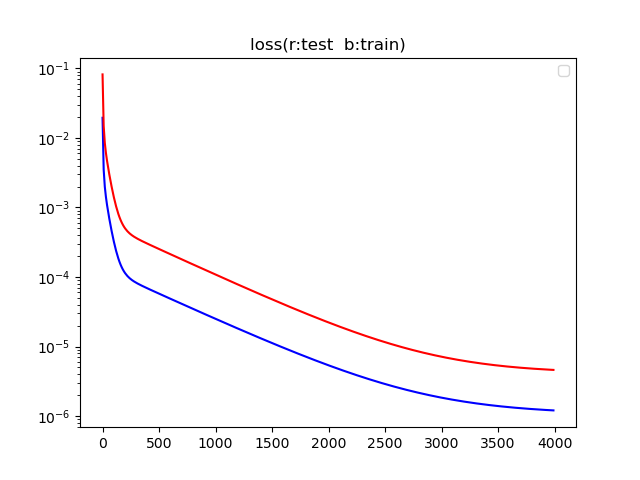

In [12]:
auto img1 = im::image("./loss.png");
img1  

# 欠拟合

In [13]:
auto train_data = 
    poly_features.index({torch::indexing::Slice(0, n_train, torch::indexing::None),
                         torch::indexing::Slice(0, 2, torch::indexing::None)});
auto train_label = 
    labels.index({torch::indexing::Slice(0, n_train, torch::indexing::None),
                         torch::indexing::Slice(0, 2, torch::indexing::None)});

auto test_data = 
    poly_features.index({torch::indexing::Slice(n_train, torch::indexing::None, torch::indexing::None),
                         torch::indexing::Slice(0, 2, torch::indexing::None)});
auto test_label = 
    labels.index({torch::indexing::Slice(n_train, torch::indexing::None, torch::indexing::None),
                         torch::indexing::Slice(0, 2, torch::indexing::None)});


printT(train_data.size(0));
printT(train_data.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}));    
printT(train_label.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}));    

train_data.size(0) = 
800
<<--->>

train_data.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}) = 
 1.0000  0.3411
 1.0000 -0.6781
[ CPUFloatType{2,2} ]
<<--->>

train_label.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}) = 
 5.2098
 1.7689
[ CPUFloatType{2,1} ]
<<--->>



In [14]:
if(!x.empty()) std::vector <int>().swap(x);
if(!y.empty()) std::vector <double>().swap(y);
if(!y_hat.empty()) std::vector <double>().swap(y_hat);

auto w = train(train_data, test_data, train_label, test_label, 4000);

Epoch 0, sum(loss_values) = 1.58522
Epoch 400, sum(loss_values) = 0.204847
Epoch 800, sum(loss_values) = 0.0770118
Epoch 1200, sum(loss_values) = 0.0562993
Epoch 1600, sum(loss_values) = 0.0552973
Epoch 2000, sum(loss_values) = 0.0669602
Epoch 2400, sum(loss_values) = 0.0595451
Epoch 2800, sum(loss_values) = 0.0993729
Epoch 3200, sum(loss_values) = 0.086711
Epoch 3600, sum(loss_values) = 0.121367
 3.9275  2.7975
[ CPUFloatType{1,2} ]


In [17]:
//true_w
// = {5.0, 1.2, -3.4, 5.6};

w = w.reshape({2,1});
printT(train_label[0]);
printT(train_data[0].reshape({1,2}).mm(w));

printT(test_label[3]);
printT(test_data[3].reshape({1,2}).mm(w));

train_label[0] = 
 5.2098
[ CPUFloatType{1} ]
<<--->>

train_data[0].reshape({1,2}).mm(w) = 
 4.8818
[ CPUFloatType{1,1} ]
<<--->>

test_label[3] = 
 3.9293
[ CPUFloatType{1} ]
<<--->>

test_data[3].reshape({1,2}).mm(w) = 
 2.8486
[ CPUFloatType{1,1} ]
<<--->>



In [18]:
plt::semilogy(x, y, "b");
plt::semilogy(x, y_hat, "r");

plt::title("loss_underfit(r:test  b:train)");
plt::legend();
plt::save("./loss_underfit.png"); 
plt::show();

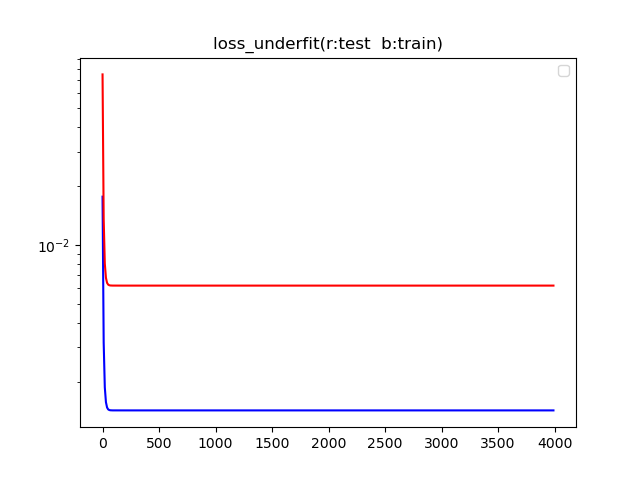

In [19]:
auto img2 = im::image("./loss_underfit.png");
img2

# 过拟合

In [20]:
#define W_OVERFIT (20)

auto train_data = 
    poly_features.index({torch::indexing::Slice(0, n_train, torch::indexing::None),
                         torch::indexing::Slice(0, W_OVERFIT, torch::indexing::None)});
auto train_label = 
    labels.index({torch::indexing::Slice(0, n_train, torch::indexing::None),
                         torch::indexing::Slice(0, W_OVERFIT, torch::indexing::None)});

auto test_data = 
    poly_features.index({torch::indexing::Slice(n_train, torch::indexing::None, torch::indexing::None),
                         torch::indexing::Slice(0, W_OVERFIT, torch::indexing::None)});
auto test_label = 
    labels.index({torch::indexing::Slice(n_train, torch::indexing::None, torch::indexing::None),
                         torch::indexing::Slice(0, W_OVERFIT, torch::indexing::None)});


printT(train_data.size(0));
printT(train_data.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}));    
printT(train_label.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}));    

train_data.size(0) = 
800
<<--->>

train_data.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}) = 
Columns 1 to 6 1.0000e+00  3.4114e-01  1.1638e-01  1.9850e-02  2.2572e-03  1.9251e-04
 1.0000e+00 -6.7814e-01  4.5987e-01 -1.5593e-01  3.5247e-02 -5.9757e-03

Columns 7 to 12 1.3135e-05  7.4782e-07  3.6401e-08  1.5520e-09  5.8825e-11  2.0068e-12
 8.1047e-04 -9.1729e-05  8.8759e-06 -7.5225e-07  5.6680e-08 -3.8437e-09

Columns 13 to 18 6.2235e-14  1.7692e-15 -1.3463e-16 -4.5926e-17 -1.5667e-17 -5.3447e-18
 2.3696e-10 -1.3391e-11 -2.0255e-12  1.3736e-12 -9.3149e-13  6.3168e-13

Columns 19 to 20-1.8233e-18 -6.2200e-19
-4.2837e-13  2.9049e-13
[ CPUFloatType{2,20} ]
<<--->>

train_label.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}) = 
 5.2098
 1.7689
[ CPUFloatType{2,1} ]
<<--->>



In [21]:
if(!x.empty()) std::vector <int>().swap(x);
if(!y.empty()) std::vector <double>().swap(y);
if(!y_hat.empty()) std::vector <double>().swap(y_hat);

auto w = train(train_data, test_data, train_label, test_label, 4000);

Epoch 0, sum(loss_values) = 1.46769
Epoch 400, sum(loss_values) = 0.00410306
Epoch 800, sum(loss_values) = 0.00202265
Epoch 1200, sum(loss_values) = 0.00179682
Epoch 1600, sum(loss_values) = 0.000636524
Epoch 2000, sum(loss_values) = 0.000518421
Epoch 2400, sum(loss_values) = 0.000179291
Epoch 2800, sum(loss_values) = 0.00016441
Epoch 3200, sum(loss_values) = 0.000121148
Epoch 3600, sum(loss_values) = 8.08516e-05
Columns 1 to 10 5.0407  1.2497 -3.3163  5.3947 -0.5182  0.7026 -0.0746  0.0528 -0.1945 -0.1657

Columns 11 to 20 0.1028  0.0138  0.0791  0.0373  0.0983 -0.0611 -0.1642  0.2056 -0.1613  0.0786
[ CPUFloatType{1,20} ]


In [22]:
//true_w
// = {5.0, 1.2, -3.4, 5.6};

w = w.reshape({W_OVERFIT,1});
printT(train_label[0]);
printT(train_data[0].reshape({1,W_OVERFIT}).mm(w));

printT(test_label[3]);
printT(test_data[3].reshape({1,W_OVERFIT}).mm(w));

train_label[0] = 
 5.2098
[ CPUFloatType{1} ]
<<--->>

train_data[0].reshape({1,W_OVERFIT}).mm(w) = 
 5.1871
[ CPUFloatType{1,1} ]
<<--->>

test_label[3] = 
 3.9293
[ CPUFloatType{1} ]
<<--->>

test_data[3].reshape({1,W_OVERFIT}).mm(w) = 
 3.9086
[ CPUFloatType{1,1} ]
<<--->>



In [23]:
plt::semilogy(x, y, "b");
plt::semilogy(x, y_hat, "r");

plt::title("loss_overfit(r:test  b:train)");
plt::legend();
plt::save("./loss_overfit.png"); 
plt::show();

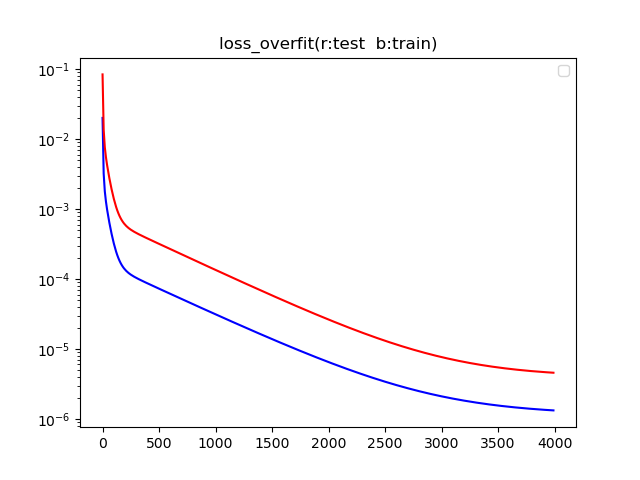

In [24]:
auto img2 = im::image("./loss_overfit.png");
img2